In [1]:
import Pkg; Pkg.activate(@__DIR__);
Pkg.add("ControlSystems");
Pkg.add("OSQP");
Pkg.add("Plots");
Pkg.add("SparseArrays");
Pkg.add("LinearAlgebra");
Pkg.add("ForwardDiff");
Pkg.add("MeshCat");
Pkg.add("RobotZoo");
Pkg.add("CoordinateTransformations");
Pkg.add("Rotations");
Pkg.add("Colors");
Pkg.add("StaticArrays");
Pkg.add("RobotDynamics");
Pkg.add("GeometryBasics");
Pkg.add("Test");
Pkg.add("Metaheuristics");
Pkg.instantiate()

  Activating project at `/notebooks/notebooks`
   Resolving package versions...
  No Changes to `/notebooks/notebooks/Project.toml`
  No Changes to `/notebooks/notebooks/Manifest.toml`
   Resolving package versions...
  No Changes to `/notebooks/notebooks/Project.toml`
  No Changes to `/notebooks/notebooks/Manifest.toml`
   Resolving package versions...
  No Changes to `/notebooks/notebooks/Project.toml`
  No Changes to `/notebooks/notebooks/Manifest.toml`
   Resolving package versions...
  No Changes to `/notebooks/notebooks/Project.toml`
  No Changes to `/notebooks/notebooks/Manifest.toml`
   Resolving package versions...
  No Changes to `/notebooks/notebooks/Project.toml`
  No Changes to `/notebooks/notebooks/Manifest.toml`
   Resolving package versions...
  No Changes to `/notebooks/notebooks/Project.toml`
  No Changes to `/notebooks/notebooks/Manifest.toml`
   Resolving package versions...
  No Changes to `/notebooks/notebooks/Project.toml`
  No Changes to `/notebooks/notebooks/Ma

In [2]:
using LinearAlgebra
using Plots
using SparseArrays
using ForwardDiff
using ControlSystems
using OSQP
using Test
using Metaheuristics

In [3]:
#Model parameters
"""
   Test -The model of the quadrotor
"""
mutable struct Model
    g::Float64 # gravity
    m::Float64 # mass
    ℓ::Float64 # inter-propeller distance
    J::Float64 # inertia momment
    R::Float64 # propeller radius
    prop_min_h::Float64 # 
    ρ::Float64 # GE correction factor (https://doi.org/10.1109/ChiCC.2015.7260521)
    umin::Vector{Float64} # Thrust inferior limit
    umax::Vector{Float64} # Thrust superior limit
end

"""
Todo..
"""
struct Simulation
    h::Float64      # Time Step
    Tfinal::Float64 # Final simulation time (it always start from time 0)
    Nt::Int64     # Number of time-steps
    #time_history::Vector{Float64} # Stores

    function Simulation(h, Tfinal)
        Nt = Int(Tfinal/h) + 1    # number of time steps
        #time_history = Array(range(0, h * (Nt-1), step=h))
        new(h, Tfinal, Nt)
    end
end

"""
    Defines the trajectory parameters, the trajectory for now is a sine
"""
mutable struct Trajectory
    Amp::Float64    # Sine amplitude - [meters]
    freq::Float64   # Sine frequency - [Hz]
end

#traj_params = Trajectory(0.1, 0.3)

Trajectory

In [4]:
function ground_effect(height, prop_radius, adjust_factor, height_saturation)
    saturated_height = max(height, height_saturation)
    return (1/(1 - adjust_factor*(prop_radius/(4*saturated_height))^2))
end

ground_effect (generic function with 1 method)

In [5]:
"""
TODO...
"""
function traj_y(traj_params, t)
    local A = traj_params.Amp
    local f = traj_params.freq
    
    return A * sin(2*pi*f*t)
end

"""
TODO...
"""
function traj_y_dot(traj_params, t)
    local A = traj_params.Amp
    local f = traj_params.freq
    
    return (A*2*pi*f) * cos(2*pi*f*t)
end
"""
    h - time step
"""
function gen_ref(state_space, traj_params, tunning_params, t, h)
    local Nh = tunning_params.Nh
    local Nx = state_space.Nx
    x_ref = zeros(Nx * Nh) # Initialize the reference with zeros
    
    for j = 1:Nh # for each element on the predictive horizon
        x_ref[Nx*(j-1) + 2] = traj_y(traj_params, (t+j)*h)
        x_ref[Nx*(j-1) + 5] = traj_y_dot(traj_params, (t+j)*h)
    end

    return x_ref
end

gen_ref

In [6]:
#Planar Quadrotor Dynamics for modeling
"""
TODO...
"""
function quad_dynamics(model, x, u, plat_h)
    θ = x[3]

    GE = ground_effect(x[2] - plat_h, model.R, model.ρ, model.prop_min_h)
    
    ẍ = (1/model.m)*(u[1] + u[2])*sin(θ)*GE
    
    ÿ = (1/model.m)*(u[1] + u[2])*cos(θ)*GE - model.g
    
    ô= (1/model.J)*(model.ℓ/2)*(u[2] - u[1])
    
    return [x[4:6]; ẍ; ÿ; ô]
end

quad_dynamics

In [7]:
"""
TODO...
"""
function dynamics_rk4(x,u, dynamics, sim_param)
    #RK4 integration with zero-order hold on u
    local h = sim_param.h
    
    # VERIFICAR A ALTURA ADEQUADA DA PLATAFORMA (Se é adequada para o RK4)
    f1 = dynamics(x, u)
    f2 = dynamics(x + 0.5 * h * f1, u)
    f3 = dynamics(x + 0.5 * h * f2, u)
    f4 = dynamics(x + h * f3, u)
    return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

dynamics_rk4

In [8]:
function find_hover_conditions(model, height)
    #@test height >= model.prop_min_h
    x_hover = [0.0, max(height, model.prop_min_h), 0.0, 0.0, 0.0, 0.0]
    weight = model.m * model. g
    GE = ground_effect(height, model.R, model.ρ, model.prop_min_h)
    u_hover = [
        0.5* weight / GE;
        0.5* weight / GE
    ]
    return x_hover, u_hover
end

find_hover_conditions (generic function with 1 method)

In [9]:
mutable struct MPCTunningParameters
    Nh::Int64           # Predictive horizon
    Nc::Int64           # Control horizon (Nc < Nh)
    Q::Matrix{Float64}  # Stage State Cost Penalty
    R::Matrix{Float64}  # Stage Control Cost Penalty
    Qn::Matrix{Float64} # Terminal State Cost Penalty
end

In [10]:
#Cost function
function cost(xhist,uhist)
    cost = 0.5*xhist[:,end]'*Qn*xhist[:,end]
    for k = 1:(size(xhist,2)-1)
        cost = cost + 0.5*xhist[:,k]'*Q*xhist[:,k] + 0.5*(uhist[k]'*R*uhist[k])[1]
    end
    return cost
end

cost (generic function with 1 method)

In [11]:
"""
TODO...
"""
struct LinearStateSpace
    Nx::Int64          # State vector dimension
    Nu::Int64          # Control vector dimension
    A::Matrix{Float64} # State Matrix
    B::Matrix{Float64} # Control Matrix
    x_hover::Vector{Float64}   # x value for which the linearization was made
    u_hover::Vector{Float64}   # u value for which the linearization was made

    function LinearStateSpace(model, simulation, Nx, Nu, height)
        x_hover, u_hover = find_hover_conditions(model, height)
        A = ForwardDiff.jacobian(x->
            dynamics_rk4(x, u_hover, (x,u)->quad_dynamics(model, x, u, height), simulation)
            ,x_hover)

        B = ForwardDiff.jacobian(u -> 
            dynamics_rk4(x_hover, u, (x,u)->quad_dynamics(model, x, u, height), simulation)
        , u_hover)
        
        new(Nx, Nu, A, B, x_hover, u_hover)
    end
end

"""
TODO...
"""
mutable struct MPCMatrices
    P::Matrix{Float64}
    U::Matrix{Float64}
    Θ::Matrix{Float64}
    H::SparseMatrixCSC{Float64,Int64}
    b::Vector{Float64}
    C::SparseMatrixCSC{Float64,Int64}
    Y::Matrix{Float64}
    D::SparseMatrixCSC{Float64,Int64}
    lb::Vector{Float64}
    ub::Vector{Float64}
    """
        trajectory is temporarily here because i'm trying to make the problem linear again...
    """
    function MPCMatrices(model, state_space, tunning_params, trajectory)
        A = state_space.A
        B = state_space.B
        Q = tunning_params.Q
        R = tunning_params.R
        Qn = tunning_params.Qn
        Nx = state_space.Nx
        Nu = state_space.Nu
        Nh = tunning_params.Nh
        Nc = tunning_params.Nc
        x_hover = state_space.x_hover
        u_hover = state_space.u_hover
        
        # Compute P from dare (Direct a... Ricatti Equation)
        P = dare(A, B, Q, R) # daRicattiEquation (Pq isso ta aqui??) STUDY THIS!!!
        
        U = kron(Diagonal(I,Nh), [I zeros(Nu,Nx)]) # Matrix that picks out all u
        Θ = kron(Diagonal(I,Nh), [0 0 0 0 1 0 0 0]) # Matrix that picks out all x3 (θ) ... explain this better TODO!!
        H = sparse([kron(Diagonal(I,Nh-1),[R zeros(Nu,Nx); zeros(Nx,Nu) Q]) zeros((Nx+Nu)*(Nh-1), Nx+Nu); zeros(Nx+Nu,(Nx+Nu)*(Nh-1)) [R zeros(Nu,Nx); zeros(Nx,Nu) P]])
        b = zeros(Nh*(Nx+Nu))
        C = sparse([[B -I zeros(Nx,(Nh-1)*(Nu+Nx))]; zeros(Nx*(Nh-1),Nu) [kron(Diagonal(I,Nh-1), [A B]) zeros((Nh-1)*Nx,Nx)] + [zeros((Nh-1)*Nx,Nx) kron(Diagonal(I,Nh-1),[zeros(Nx,Nu) Diagonal(-I,Nx)])]])
        # Cria uma matriz que seleciona o 4º elemento do bloco (ou seja, o y)
        Y = kron(Diagonal(I, Nh), [0 0 0 1 0 0 0 0])
        D = [C; U; Θ; Y]
        #local x_hover, u_hover = find_hover_conditions(model, temp_height) # Solve this problem TODO!

        lb = [zeros(Nx*Nh);
              kron(ones(Nh), model.umin - u_hover);
              -0.2 * ones(Nh);
              -4.0 * ones(Nh)]
        ub = [zeros(Nx*Nh);
              kron(ones(Nh), model.umax - u_hover);
              0.2 * ones(Nh);
              4.0 * ones(Nh)]
        new(P, U, Θ, H, b, C, Y, D, lb, ub)
    end
end

MPCMatrices

In [12]:
#MPC Controller
function mpc_controller(model, simulation, tunning_params, trajectory, t, x, xref)
    Q = tunning_params.Q
    Nh = tunning_params.Nh
    height = x[2] - xref[2]
    Nu = 2
    Nx = 6
    
    lstate_space = LinearStateSpace(model, simulation, Nx, Nu, height)
    
    A_prime = lstate_space.A
    B_prime = lstate_space.B
    x_hover = lstate_space.x_hover
    u_hover = lstate_space.u_hover
    
    # ....
    mpc_mats = MPCMatrices(model, lstate_space, tunning_params, trajectory)
    
    P = mpc_mats.P
    H = mpc_mats.H
    b = mpc_mats.b
    D = mpc_mats.D
    lb = mpc_mats.lb
    ub = mpc_mats.ub
      
    #Update QP problem
    lb[1:6] .= -A_prime*x
    ub[1:6] .= -A_prime*x

    # Atualiza os limites para a restrição Y
    # Índices para Y: (Nx*Nh + 2*Nh + 1) até (Nx*Nh + 3*Nh)
    
    #y_indices = (Nx*Nh + 3*Nh + 1):(Nx*Nh + 4*Nh)
    #lb[y_indices] .= xref[Nx + 2]
    
    #println(xref[Nh*Nx-4])
    # Efetua "rastreamento de referência"
    # Cte se xref não mudar
    for j = 1:(Nh-1)
        b[(Nu+(j-1)*(Nx+Nu)).+(1:Nx)] .= -Q*xref[1 + Nx*(j-1):Nx* j]
        #b[(Nu+(j-1)*(Nx+Nu)).+(1:Nx)] .= -Q*xref[1:Nx]
    end
    b[(Nu+(Nh-1)*(Nx+Nu)).+(1:Nx)] .= -P*xref[(Nh*Nx-Nx)+1:Nx*Nh]
    #b[(Nu+(Nh-1)*(Nx+Nu)).+(1:Nx)] .= -P*xref[1:Nx]
    #OSQP.update!(prob, q=b, l=lb, u=ub)
    prob = OSQP.Model()
    OSQP.setup!(prob; P=H, q=b, A=D, l=lb, u=ub, verbose=false, eps_abs=1e-8, eps_rel=1e-8, polish=1);

    #Solve QP
    results = OSQP.solve!(prob)
    Δu = results.x[1:Nu]
    #println(results.x)

    return u_hover + Δu
end

mpc_controller (generic function with 1 method)

In [13]:
function verify_landing(x, x_ref)
    #crit = [0.05; 0.05; 0.05; 0.10; 0.02; 0.1]
    crit = [1.0; 0.1; 1.0; 1.0; 1.0; 1.0]

    sucess_check = true
    for i = 1:(Nx)
        if (abs(x[i] - x_ref[i]) >= crit[i])
             sucess_check = false
        end
    end
    
    return ~sucess_check
end

verify_landing (generic function with 1 method)

In [14]:
function closed_loop(x0, state_space, tunning_params, traj_params, simulation, model, controller, N)
    h = simulation.h
    umax = model.umax
    umin = model.umin
    
    xhist = zeros(length(x0),N)
    u0 = controller(1,x0)
    uhist = zeros(length(u0),N-1)
    plathist = zeros(N)
    
    uhist[:,1] .= u0
    xhist[:,1] .= x0
    
    not_landed = true
    land_time = 0.0
    
    for k = 1:(N-1)
        curr_time_instant = k * h
        plathist[k] = traj_y(traj_params, curr_time_instant) #0.1 * sin(2*pi* 0.3 *(k*simulation.h))
        
        uk = controller(k, xhist[:,k])
        uhist[:,k] = max.(min.(umax, uk), umin) #enforce control limits
        height = xhist[2,k] - plathist[k]
        xhist[:,k+1] .= dynamics_rk4(xhist[:,k],uhist[:,k],(x,u)->quad_dynamics(model, x, u, height), simulation)

        if not_landed
            # gen_ref(state_space, traj_params, mpc_params, t, simulation.h)
            not_landed = verify_landing(xhist[:,k+1], gen_ref(state_space, traj_params, tunning_params, curr_time_instant, simulation.h))
            land_time = curr_time_instant
        end
    end
    return xhist, uhist, plathist, land_time
end

closed_loop (generic function with 1 method)

In [15]:
landing_start_height = 3.0

## Model Configs
#    g::Float64 # gravity
#    m::Float64 # mass
#    ℓ::Float64 # inter-propeller distance
#    J::Float64 # inertia momment
#    R::Float64 # propeller radius
#    prop_min_h::Float64 # 
#    ρ::Float64 # GE correction factor (https://doi.org/10.1109/ChiCC.2015.7260521)
#    umin::Vector{Float64} # Thrust inferior limit
#    umax::Vector{Float64} # Thrust superior limit

model = Model(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, [0.0, 0.0], [0.0, 0.0])
model.g = 9.81 # [m/s^2]
model.m = 1.0 # [kg]
model.ℓ = 0.3 # [meters]
model.J = 0.2 * model.m * model.ℓ * model.ℓ # [kg . m^2]
model.R = 0.15 # [meters]
model.prop_min_h = 0.1 # [meters]
model.ρ = 1.0 # dimensionless

#Thrust limits
model.umin = [0.0 * model.m * model.g; 0.0 * model.m * model.g]
model.umax = [2.0 * model.m * model.g; 2.0 * model.m * model.g]

## Simulation Configs

h = 0.05 # Time step (20 Hz)
Tfinal = 10.0 # Simulate from 0 - 10 seconds

simulation = Simulation(h, Tfinal)

## Trajectory configuration
#mutable struct Trajectory
#    Amp::Float64    # Sine amplitude - [meters]
#    freq::Float64   # Sine frequency - [Hz]
#end

traj_params = Trajectory(0.1, 0.3)

## Linear State Space Configs ???
#struct LinearStateSpace
#    Nx::Int64          # State vector dimension
#    Nu::Int64          # Control vector dimension
#    A::Matrix{Float64} # State Matrix
#    B::Matrix{Float64} # Control Matrix
#    x_hover::Float64   # x value for which the linearization was made
#    u_hover::Float64   # u value for which the linearization was made
Nx = 6
Nu = 2

#    function LinearStateSpace(model, simulation, Nx, Nu, height)
state_space = LinearStateSpace(model, simulation, Nx, Nu, landing_start_height)

## Tunning Parameters Configs
# mutable struct MPCTunningParameters
#    Nh::Int64           # Predictive horizon
#    Nc::Int64           # Control horizon (Nc < Nh)
#    Q::Matrix{Float64}  # Stage State Cost Penalty
#    R::Matrix{Float64}  # Stage Control Cost Penalty
#    Qn::Matrix{Float64} # Terminal State Cost Penalty
#end
Nh = 50
Nc = 42 # For now is unused...

# Cost weights
Q = Array(100.0*I(Nx));
R = Array(.01*I(Nu));
Qn = Array(10.0*I(Nx));

tunning_params = MPCTunningParameters(Nh, Nc, Q, R, Qn)

## MPC Matrices Configs

#mutable struct MPCMatrices
#    P::Matrix{Float64}
#    U::Matrix{Float64}
#    Θ::Matrix{Float64}
#    H::SparseMatrixCSC{Float64,Int64}
#    b::Array{Float64,1}
#    C::SparseMatrixCSC{Float64,Int64}
#    Y::Matrix{Float64}
#    D::Array{Float64,1}
#    lb::Array{Float64,1}
#    ub::Array{Float64,1}

# function MPCMatrices(model, state_space, tunning_params, trajectory)
#mpc_mats =  MPCMatrices(model, state_space, tunning_params, traj_params)

MPCTunningParameters(50, 42, [100.0 0.0 … 0.0 0.0; 0.0 100.0 … 0.0 0.0; … ; 0.0 0.0 … 100.0 0.0; 0.0 0.0 … 0.0 100.0], [0.01 0.0; 0.0 0.01], [10.0 0.0 … 0.0 0.0; 0.0 10.0 … 0.0 0.0; … ; 0.0 0.0 … 10.0 0.0; 0.0 0.0 … 0.0 10.0])

In [16]:
#x_ref = [0.0; 1.0; 0; 0; 0; 0]
x0 = [1.0; landing_start_height; 0.0; 0; 0; 0]

#xhist1, uhist1 = closed_loop(x0, (t,x)->lqr_controller(t,x,K,x_ref), Nt);
#xhist2, uhist2 = closed_loop(x0, (t,x)->mpc_controller(t,x,x_ref), Nt);
xhist3, uhist3, plathist3, land_time = closed_loop(
    x0,
    state_space,
    tunning_params, 
    traj_params,
    simulation,
    model,
    # mpc_controller(model, simulation, tunning_params, trajectory, t, x, xref)
    (t, x) -> mpc_controller(
        model,
        simulation,
        tunning_params,
        traj_params,
        t,
        x, 
        gen_ref(state_space, traj_params, tunning_params, t, simulation.h) # verify if this works as expected!!
    ), 
    simulation.Nt
);

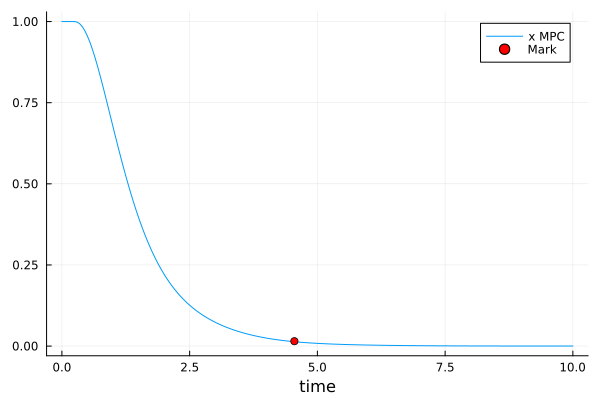

In [17]:
thist = Array(range(0, simulation.h * (simulation.Nt-1), step=simulation.h));

#plot(thist, xhist1[1, :], label="x LQR")
plot(thist, xhist3[1, :], label="x MPC")
scatter!([land_time], [xhist3[1,trunc(Int, land_time/simulation.h)]], label="Mark", color=:red, markersize=4)

xlabel!("time")

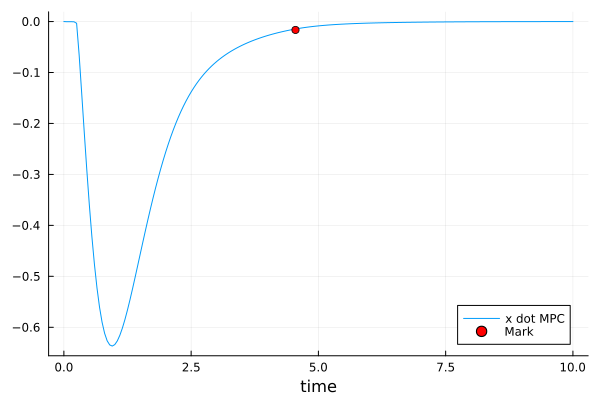

In [18]:
plot(thist, xhist3[4, :], label="x dot MPC")
scatter!([land_time], [xhist3[4,trunc(Int, land_time/simulation.h)]], label="Mark", color=:red, markersize=4)

xlabel!("time")

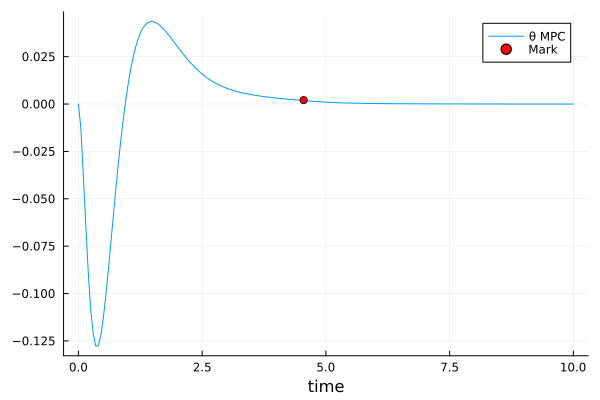

In [19]:
#plot(thist,xhist1[2,:], label="y LQR")
plot(thist,xhist3[3,:], label="θ MPC")
scatter!([land_time], [xhist3[3,trunc(Int, land_time/simulation.h)]], label="Mark", color=:red, markersize=4)
xlabel!("time")

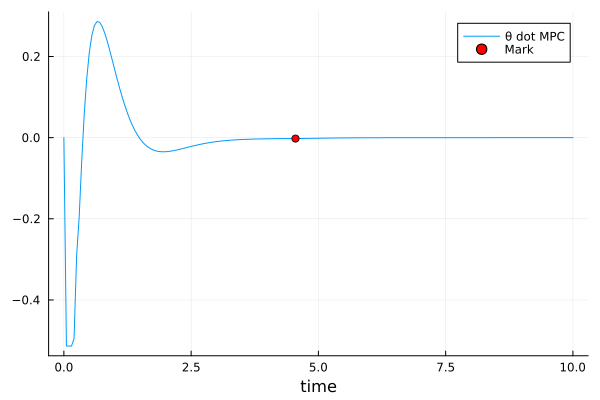

In [20]:
plot(thist, xhist3[6, :], label="θ dot MPC")
scatter!([land_time], [xhist3[6,trunc(Int, land_time/simulation.h)]], label="Mark", color=:red, markersize=4)

xlabel!("time")

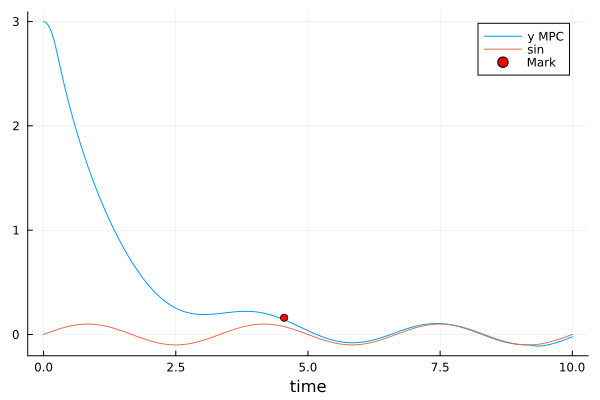

In [21]:
## Plot de interesse|
plot(thist,xhist3[2,:], label="y MPC")
plot!(thist, 0.1*sin.(2*pi*0.3*thist), label="sin")

xlabel!("time")
scatter!([land_time], [xhist3[2,trunc(Int, land_time/simulation.h)]], label="Mark", color=:red, markersize=4)

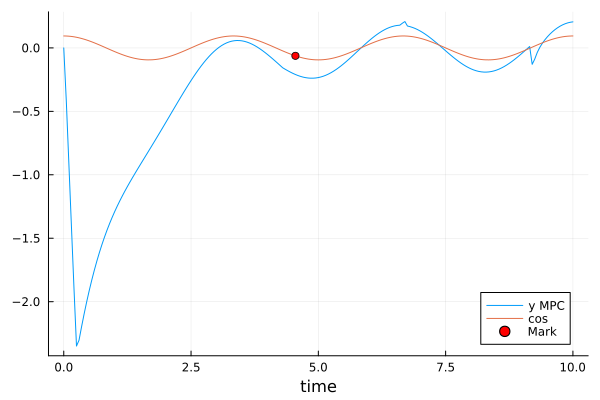

In [22]:
plot(thist,xhist3[5,:], label="y MPC")
plot!(thist, 0.1*pi*0.3*cos.(2*pi*0.3*thist), label="cos")

xlabel!("time")
scatter!([land_time], [0.1*pi*0.3*cos.(2*pi*0.3*land_time)], label="Mark", color=:red, markersize=4)

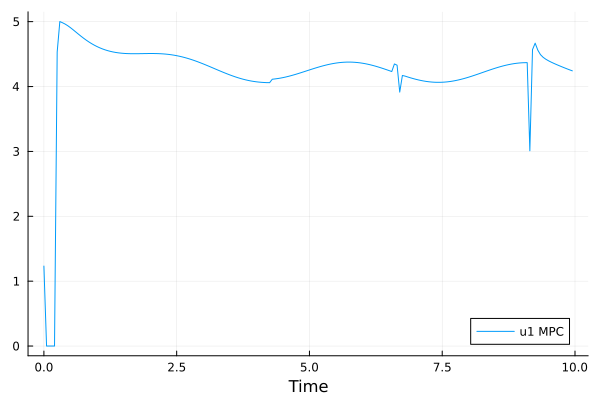

In [23]:
plot(thist[1:end-1], uhist3[1,:], label="u1 MPC")
xlabel!("Time")

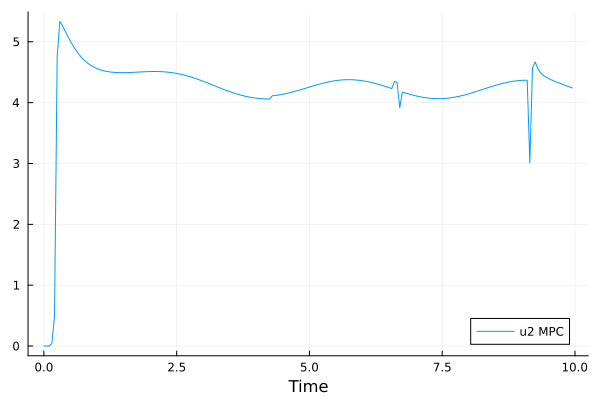

In [24]:
plot(thist[1:end-1], uhist3[2,:], label="u2 MPC")
xlabel!("Time")

In [39]:
## Now tune the controller

function fitness(model, simulation, traj_params, state_space, gene)
    Nx = state_space.Nx
    Nu = state_space.Nu
    
    # Build tunning matrices from gene
    Q = diagm(gene[1:Nx])#Array(100.0*I(Nx));
    R = diagm(gene[(Nx + 1):(Nx + Nu)])#Array(.01*I(Nu));
    Qn = diagm(gene[(Nx + Nu + 1):(2*Nx + Nu)])#Array(10.0*I(Nx));
    Nh = gene[2*Nx + Nu + 1]
    Nc = 42 # Unused

    tunning_params = MPCTunningParameters(Nh, Nc, Q, R, Qn)
    xhist, uhist, plathist, land_time = closed_loop(
        x0,
        state_space,
        tunning_params, 
        traj_params,
        simulation,
        model,
        # mpc_controller(model, simulation, tunning_params, trajectory, t, x, xref)
        (t, x) -> mpc_controller(
            model,
            simulation,
            tunning_params,
            traj_params,
            t,
            x, 
            gen_ref(state_space, traj_params, tunning_params, t, simulation.h) # verify if this works as expected!!
        ), 
        simulation.Nt
    );

    return land_time
end

Nx = state_space.Nx
Nu = state_space.Nu

bounds = repeat([0,1000], 1, (2 * Nx + Nu + 1))
println(size(bounds))
# Control Horizon limitation
bounds[1, 2*Nx + Nu + 1] = 1
bounds[2, 2*Nx + Nu + 1] = 25

pop_size = 100
#options = Options(parallel_evaluation=true)
ga = GA(;
#    options = options,
    N = pop_size,
    p_mutation = 1e-2, # 0.00001
    #p_crossover = 0.5, # 50 %
    #initializer = RandomInBounds(pop_size), # What are other options?
    mutation = PolynomialMutation(;bounds), # What are the types?
    crossover=SBX(;bounds), # What is it?
                environmental_selection=GenerationalReplacement() # Lembro mais ou menos
);


(2, 15)


In [40]:
#dgene = ones(2*Nx + Nu + 1)
#dgene[2*Nx + Nu + 1] = 1
#fitness(model, simulation, traj_params, state_space, dgene)
result = optimize((gene) -> fitness(model, simulation, traj_params, state_space, gene), bounds, ga)
println(result)
println(minimizer(result))
bgene = minimizer(result)

Optimization Result
  Iteration:       1
  Minimum:         10
  Minimizer:       [623, 98, 418, …, 20]
  Function calls:  100
  Total time:      19.0935 s
  Stop reason:     Due to Convergence Termination criterion.

[623, 98, 418, 249, 281, 443, 762, 236, 25, 462, 137, 187, 849, 303, 20]


15-element Vector{Int64}:
 623
  98
 418
 249
 281
 443
 762
 236
  25
 462
 137
 187
 849
 303
  20

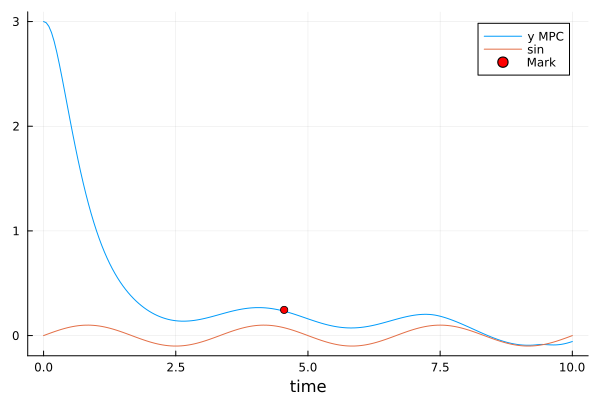

In [43]:
bgene = [204, 979, 558, 799, 218, 791, 11, 85, 1, 807, 918, 383, 457, 295, 7]
Nx = state_space.Nx
Nu = state_space.Nu
    
    # Build tunning matrices from gene
    Q = diagm(bgene[1:Nx])#Array(100.0*I(Nx));
    R = diagm(bgene[(Nx + 1):(Nx + Nu)])#Array(.01*I(Nu));
    Qn = diagm(bgene[(Nx + Nu + 1):(2*Nx + Nu)])#Array(10.0*I(Nx));
    Nh = bgene[2*Nx + Nu + 1]
    Nc = 42 # Unused

    tunning_params = MPCTunningParameters(Nh, Nc, Q, R, Qn)
    bxhist, buhist, bplathist, bland_time = closed_loop(
        x0,
        state_space,
        tunning_params, 
        traj_params,
        simulation,
        model,
        # mpc_controller(model, simulation, tunning_params, trajectory, t, x, xref)
        (t, x) -> mpc_controller(
            model,
            simulation,
            tunning_params,
            traj_params,
            t,
            x, 
            gen_ref(state_space, traj_params, tunning_params, t, simulation.h) # verify if this works as expected!!
        ), 
        simulation.Nt
    );

## Plot de interesse|
plot(thist,bxhist[2,:], label="y MPC")
plot!(thist, 0.1*sin.(2*pi*0.3*thist), label="sin")

xlabel!("time")
scatter!([land_time], [bxhist[2,trunc(Int, land_time/simulation.h)]], label="Mark", color=:red, markersize=4)

In [44]:
#Set up visualization
using MeshCat
using RobotZoo: Quadrotor, PlanarQuadrotor
using CoordinateTransformations, Rotations, Colors, StaticArrays, RobotDynamics
using GeometryBasics

function set_mesh!(vis, platform, model::L;
        scaling=1.0, color=colorant"black"
    ) where {L <: Union{Quadrotor, PlanarQuadrotor}} 
    # urdf_folder = joinpath(@__DIR__, "..", "data", "meshes")
    urdf_folder = @__DIR__
    # if scaling != 1.0
    #     quad_scaling = 0.085 * scaling
    obj = joinpath(urdf_folder, "quadrotor_scaled.obj")
    if scaling != 1.0
        error("Scaling not implemented after switching to MeshCat 0.12")
    end
    robot_obj = MeshFileGeometry(obj)
    mat = MeshPhongMaterial(color=color)
    setobject!(vis["robot"]["geom"], robot_obj, mat)

    setobject!(vis["platform"], platform)  # Apply the platform to the visualization
    
    # Transform the platform to position it correctly (if needed)
    settransform!(vis["platform"], Translation(platform_position))    
    
    if hasfield(L, :ned)
        model.ned && settransform!(vis["robot"]["geom"], LinearMap(RotX(pi)))
    end
end

function visualize!(vis, model::PlanarQuadrotor, x::StaticVector)
    py,pz = x[1], x[2]
    θ = x[3]
    settransform!(vis["robot"], compose(Translation(0,py,pz), LinearMap(RotX(-θ))))
end

function visualize!(vis, platform, model, tf::Real, X)
    fps = Int(round((length(X)-1)/tf))
    anim = MeshCat.Animation(fps)
    for (k,x) in enumerate(X)
        atframe(anim, k) do
            x = X[k]
            visualize!(vis, model, SVector{6}(x))
            platform_position = Vec(-0.125, -0.125, 0.1*sin.(2*pi*0.3*k*simulation.h))
            # Transform the platform to position it correctly (if needed)
            settransform!(vis["platform"], Translation(platform_position)) 
            # The line below does not works, because it says "`ccall` requires the compiler"
            #setobject!(vis["robot"], HyperRectangle(Vec(-0.25, -0.25, 0.1*sin.(2*pi*0.3*k*simulation.h)), Vec(.5, .5, .05)))
        end
    end
    setanimation!(vis, anim)
end

visualize! (generic function with 2 methods)

In [45]:
vis = Visualizer()
model = PlanarQuadrotor()
platform_size = Vec(.5, .5, .05)  # Dimensions of the platform (Length x Width x Height)
platform_position = Vec(-0.125, -0.125, -.075)  # Slightly below the quadrotor to serve as the platform
# Create the HyperRectangle (this is the platform)
platform = HyperRectangle(platform_position, platform_size)  # Create the platform geometry

set_mesh!(vis, platform, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "platform" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x70, 0x6c, 0x61, 0x74, 0x66, 0x6f, 0x72, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x74, 0x2f, 0x70, 0x6c, 0x61, 0x74, 0x66, 0x6f, 0x72, 0x6d], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{Any}(), ip"127.0.0.1", 8700))

In [46]:
#X1 = [SVector{6}(x) for x in eachcol(xhist1)];
#X2 = [SVector{6}(x) for x in eachcol(xhist2)];
X3 = [SVector{6}(x) for x in eachcol(bxhist)];

In [47]:
#visualize!(vis, model, thist[end], X1)

In [48]:
#visualize!(vis, model, thist[end], X2)

In [49]:
#setobject!(vis, HyperRectangle(Vec(-0.25, -0.25, 0), Vec(.5, .5, .05)))
#settransform!(vis, Translation(0, 0, 0))
visualize!(vis, platform, model,  thist[end], X3)
